## Data preprocessing and logistic regression for a binary classification problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../input/unimelb/unimelb_training.csv')
print(data.info())

test = pd.read_csv('../input/unimelb/unimelb_test.csv')
test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Columns: 252 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(2), object(70)
memory usage: 16.7+ MB
None


(2176, 252)

In [3]:
X = pd.concat([data, test], ignore_index= 'True').drop('Grant.Status', 1)
#X= data.drop('Grant.Status', 1)
y = data['Grant.Status']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Columns: 251 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(1), object(70)
memory usage: 20.8+ MB


In [4]:
ind,numeric_cols = X.select_dtypes(exclude=['object']).axes

ind,categorical_cols = X.select_dtypes(include=['object']).axes

print(numeric_cols.shape, categorical_cols.shape)

(181,) (70,)


In [5]:
X_real_zeros = X[numeric_cols].fillna(0.0)

"""X_real_mean = X[numeric_cols] 
for col in numeric_cols:
     X_real_mean[col]=X_real_mean[col].fillna(np.mean(X_real_mean[col]))"""
        
X_cat = X[categorical_cols].fillna('NA').astype(str)
print (X_cat.shape, X_real_zeros.shape)

(10884, 70) (10884, 181)


# One-hot encoding:

In [6]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

print (X_cat_oh.shape)

(10884, 1647)


## Features scaling

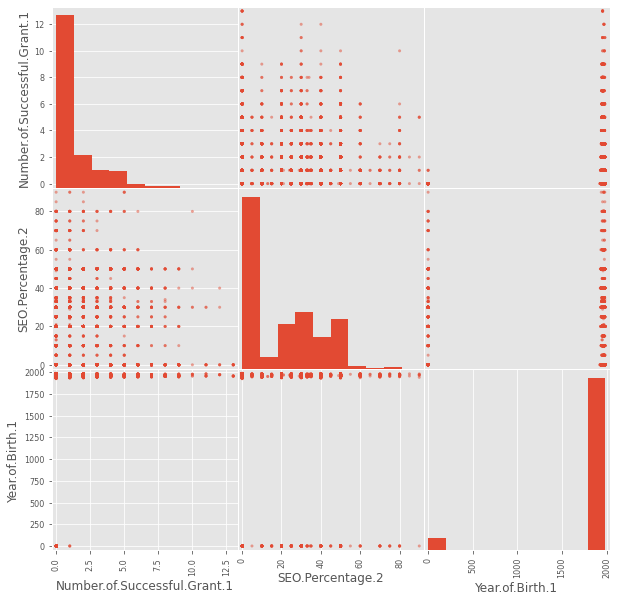

In [7]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real_zeros)
#X_real_mean_scaled = scaler.fit_transform(X_real_means)

Let's build the same graphs for the converted data:

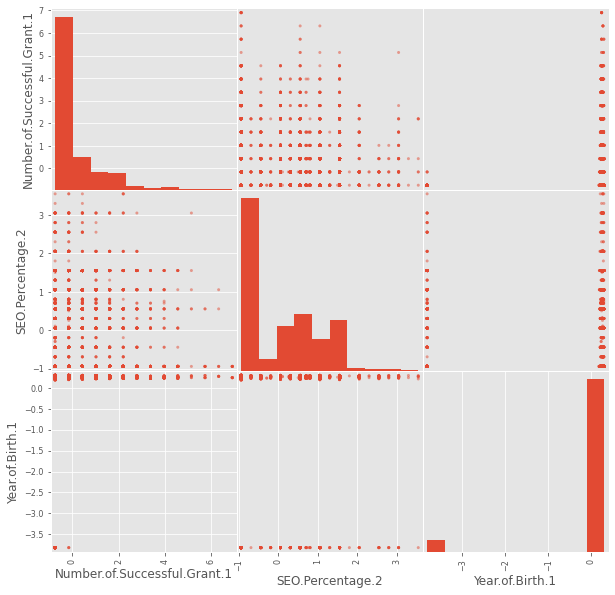

In [9]:
data_numeric_scaled = pd.DataFrame(X_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

### Let's select the validation set:

In [10]:
test_zeros=np.hstack((X_real_zeros[8708:] , X_cat_oh[8708:]))
#test_mean=np.hstack((X_real_mean [8708:] , X_cat_oh[8708:]))

X_real_zeros_cut = X_real_zeros [:8708]
#X_real_mean_cut =X_real_mean [:8708]
X_cat_oh_cut = X_cat_oh [:8708]


print(X_real_zeros.info())
print(test_zeros.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Columns: 181 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(1)
memory usage: 15.0 MB
None
(2176, 1828)


# Stratification 

In [11]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, X_test_real_zeros, y_train, y_test) = train_test_split(X_real_zeros_cut, y, test_size=0.3, stratify=y, random_state=0)
#(X_train_real_mean,  X_test_real_mean) = train_test_split(X_real_mean_cut, test_size=0.3, stratify=y, random_state=0)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_oh_cut, test_size=0.3, random_state=0, stratify=y)
print (X_train_real_zeros.shape)
y_train.shape

(6095, 181)


(6095,)

## Балансировка классов
Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [12]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

3301
2794


# Feature Selection Using Lasso Regression
+class_weight='balanced'

In [13]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

learn_zeros=np.hstack((X_train_real_zeros,X_train_cat_oh))
#learn_means=np.hstack((X_train_real_mean,X_train_cat_oh))

estimator_lasso = LogisticRegression (solver='liblinear',  class_weight='balanced', penalty = 'l1')
optimizer_zeros = GridSearchCV(estimator_lasso, param_grid,  cv=3, n_jobs=-1)                
optimizer_zeros.fit(learn_zeros, y_train)

#optimizer_means = GridSearchCV(estimator_lasso, param_grid,  cv=3, n_jobs=-1)                
#optimizer_means.fit(learn_means, y_train)


print('score_lasso', optimizer_zeros.best_score_)
print('param _lasso', optimizer_zeros.best_params_)
#print('score_zeros_Smb', optimizer_means.best_score_)

score_lasso 0.837571206018007
param _lasso {'C': 1}


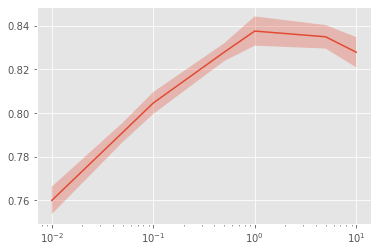

param _zeros_Smb {'C': 1}
[[-2.48371147e-04  1.53913805e-07  4.15689210e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [14]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    print('param _zeros_Smb', optimizer.best_params_)

plot_scores(optimizer_zeros)
#plot_scores(optimizer_means)


print(optimizer_zeros.best_estimator_.coef_)

In [15]:
Y = optimizer_zeros.best_estimator_.predict_proba(test_zeros)[:,0]

In [16]:
print(Y)
y_ans = pd.read_csv('../input/unimelb/unimelb_example.csv')
print(y_ans.info)
del y_ans["Grant.Status"]
y_ans['Grant.Status']=Y
print(y)

[0.00705474 0.00806123 0.88173818 ... 0.13242889 0.14620571 0.54375792]
<bound method DataFrame.info of       Grant.Application.ID  Grant.Status
0                        1      0.913801
1                        2      0.201674
2                        3      0.311615
3                        4      0.324976
4                        5      0.570575
...                    ...           ...
2171                  2172      0.561352
2172                  2173      0.326442
2173                  2174      0.350152
2174                  2175      0.514520
2175                  2176      0.804023

[2176 rows x 2 columns]>
0       1
1       1
2       1
3       1
4       0
       ..
8703    1
8704    1
8705    0
8706    1
8707    1
Name: Grant.Status, Length: 8708, dtype: int64


In [17]:
y_ans.to_csv('./GrantStatus_answer.csv')